In [15]:
import os
import json
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import Accuracy
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer
from dataclasses import dataclass, field
from typing import List, Tuple
from tqdm import tqdm
import time
from models.utils import *
from models.model import CustomRNNClassifier, RNNClassifier, TransformerClassifier

data_dir = 'D:/ComputerScience/cs_2024_Fall_Deep_Learning/Lab/data/Yelp'

In [2]:
def read_json(file_path):
        """
        Load training/test data from the specified directory
        :param data_dir: Directory containing the data files
        :param train: Whether to load the training data
        :return: List of data instances
        """
        word_counts = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                rdata = json.loads(line)
                text = rdata.get('text', None)
                star = rdata.get('stars', None)               
                word_counts.append(len(text.split()))
        return word_counts
file_path = os.path.join(data_dir, 'train.json')
word_counts = read_json(file_path)
print(max(word_counts))

1006


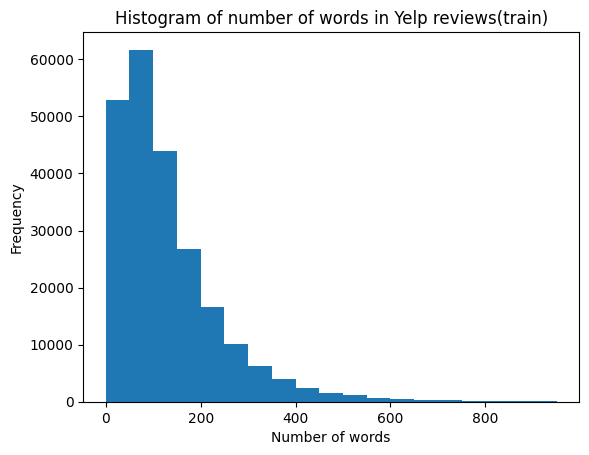

sizes of reviews: 229907
max length of review: 1006
min length of review: 0
average length of review: 130.6026088809823
median length of review: 100


In [3]:
import matplotlib.pyplot as plt
plt.hist(word_counts, bins=range(0, 1000, 50))
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Histogram of number of words in Yelp reviews(train)')
plt.show()
print("sizes of reviews:", len(word_counts))
print('max length of review:', max(word_counts))
print('min length of review:', min(word_counts))
print('average length of review:', sum(word_counts)/len(word_counts))
print('median length of review:', sorted(word_counts)[len(word_counts)//2])


In [3]:
# Define the data structure
@dataclass
class YelpData:
    text: str
    star: int

class YelpDataset(Dataset):
    def __init__(self, data_dir, tokenizer, train=True, max_length=512, reload_=False):
        """
        Dataset constructor
        :param data_dir: Directory of the data files
        :param train: Whether to load training data
        :param tokenizer_name: Name of the tokenizer to use
        :param max_length: Maximum length for padding and truncation
        """
        self.data_path = os.path.join(data_dir, 'train.json') if train else os.path.join(data_dir, 'test.json')
        self.raw_data = self._read_json(self.data_path)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = None
        if reload_:
            if train:
                save_path = os.path.join(data_dir, 'train.pt')
            else:
                save_path = os.path.join(data_dir, 'test.pt')
            if not os.path.exists(save_path):
                print("Preprocessed data not found, preprocessing...")
                self.data = self._preprocess(self.raw_data)
                torch.save(self.data, save_path)
                print(f"Preprocessed data saved to {save_path}")
            else:
                self.data = torch.load(save_path)
                print(f"Preprocessed data loaded from {save_path}")
    
    def _read_json(self, file_path):
        """
        Load training/test data from the specified directory
        :param data_dir: Directory containing the data files
        :param train: Whether to load the training data
        :return: List of data instances
        """
        data = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                try:
                    rdata = json.loads(line)
                    text = rdata.get('text', None)
                    star = rdata.get('stars', None)
                    
                    if text is not None and star is not None:
                        data.append(YelpData(text=text, star=star))
                    else:
                        print(f"{line_num} data is invalid")
                except json.JSONDecodeError as e:
                    print(f"Fails to decode line {line_num}")
        
        return data
    
    def _preprocess(self, raw_data):
        tokenizer_list = []
        mask_list = []
        label_list = []
        with tqdm(total=len(raw_data), desc="Preprocessing data") as pbar:
            for review in raw_data:
                text = review.text
                label = review.star - 1 # Convert 1-5 to 0-4
                
                # Tokenize, pad and truncate the text
                encoding = self.tokenizer(
                    text,
                    add_special_tokens=True,  # Add [CLS] and [SEP]
                    truncation=True,  # Truncate text if it exceeds max_length
                    padding='max_length',  # Pad text to max_length
                    max_length=self.max_length,
                    return_attention_mask=True,
                    return_tensors='pt'  # Return PyTorch tensors
                )
                
                tokenizer_list.append(encoding['input_ids'].squeeze(0))
                mask_list.append(encoding['attention_mask'].squeeze(0))
                label_list.append(torch.tensor(label, dtype=torch.long))
                pbar.update(1)
        
        return {
            'input_ids': torch.stack(tokenizer_list),
            'attention_mask': torch.stack(mask_list),
            'label': torch.stack(label_list)
        }


    def __len__(self):
        return len(self.raw_data)
    
    def __getitem__(self, idx):
        if self.data is None:
            text = self.raw_data[idx].text
            label = self.raw_data[idx].star
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_attention_mask=True,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].squeeze(0),
                'attention_mask': encoding['attention_mask'].squeeze(0),
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            input_ids = self.data['input_ids'][idx]
            attention_mask = self.data['attention_mask'][idx]
            label = self.data['label'][idx]
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': torch.tensor(label, dtype=torch.long)
            }


In [4]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
train_dataset = YelpDataset(data_dir, tokenizer, reload_=True)
print(f"Number of training samples: {len(train_dataset)}")
test_dataset = YelpDataset(data_dir, tokenizer, train=False, reload_=True)
print(f"Number of test samples: {len(test_dataset)}")

C:\Users\runze\AppData\Local\Temp\ipykernel_6936\1163981945.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(save_path)


Preprocessed data loaded from D:/ComputerScience/cs_2024_Fall_Deep_Learning/Lab/data/Yelp\train.pt
Number of training samples: 229907
Preprocessed data loaded from D:/ComputerScience/cs_2024_Fall_Deep_Learning/Lab/data/Yelp\test.pt
Number of test samples: 1000


In [5]:
raw0 = train_dataset.raw_data[0].text
print(raw0)
print(len(raw0.split()))

My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.

Do yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I've ever had.  I'm pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.

While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I've ever had.

Anyway, I can't wait to go back!
155


In [9]:
tokenizer0 = tokenizer(raw0, add_special_tokens=False, truncation=True, padding='max_length', max_length=512, return_attention_mask=True, return_tensors='pt')
input_ids = tokenizer0['input_ids']
attention_mask = tokenizer0['attention_mask']
print(input_ids)
print(input_ids.shape)
ids_to_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0))
print(ids_to_tokens)

tensor([[ 2026,  2564,  2165,  2033,  2182,  2006,  2026,  5798,  2005,  6350,
          1998,  2009,  2001,  6581,  1012,  1996,  4633,  2001,  3819,  2029,
          2081,  3564,  2648, 12549,  2037,  5286,  2019,  7619,  5165,  1012,
          2256, 13877,  2001,  6581,  1998,  2256,  2833,  3369,  2855,  2006,
          1996,  4100,  1011,  5697,  5095,  2851,  1012,  2009,  2246,  2066,
          1996,  2173, 17469,  2039,  3492,  2855,  2061,  1996,  3041,  2017,
          2131,  2182,  1996,  2488,  1012,  2079,  4426,  1037,  5684,  1998,
          2131,  2037,  6703,  2984,  1012,  2009,  2001, 13352,  2140,  1998,
          3432,  1996,  2190,  1045,  1005,  2310,  2412,  2018,  1012,  1045,
          1005,  1049,  3492,  2469,  2027,  2069,  2224, 12760,  2013,  2037,
          3871,  1998, 12586,  2068,  4840,  2043,  2017,  2344,  2009,  1012,
          2009,  2001,  6429,  1012,  2096,  2673,  2006,  1996, 12183,  3504,
          6581,  1010,  1045,  2018,  1996,  2317, 1

C:\Users\runze\AppData\Local\Temp\ipykernel_22576\1163981945.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)


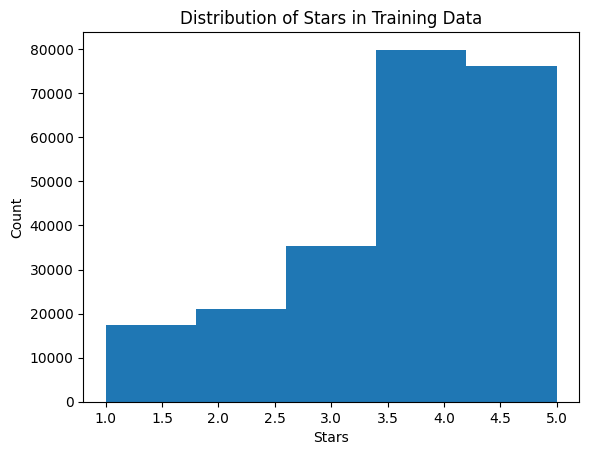

In [4]:
stars = [data['label']+1 for data in train_dataset]
import matplotlib.pyplot as plt
plt.hist(stars, bins=5)
plt.xlabel('Stars')
plt.ylabel('Count')
plt.title('Distribution of Stars in Training Data')
plt.show()

In [12]:
spilt_ratio = 0.8
train_size = int(spilt_ratio * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

In [13]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

In [14]:
print(train_dataset[0])

{'input_ids': tensor([  101,  6359,  7224,   999,  1996,  2833,  2003,  7929,  2021,  1996,
         8974,  2024,  2844,  1012,  3046,  1996,  6901,  7975, 11642,  1012,
         2035,  1996, 15812,  2015,  2024,  2307,  1012,  4638,  2009,  2041,
         1010,  2049,  2488,  2008,  7570, 12184,  2869,   999,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

C:\Users\runze\AppData\Local\Temp\ipykernel_15292\1163981945.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'label': torch.tensor(label, dtype=torch.long)


In [6]:
rnn = nn.RNN(input_size=128, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True).to('cuda')
embedding_output = torch.rand(8, 512, 128).to('cuda')


print(embedding_output.size())
    
output, hidden = rnn(embedding_output)
print(output.size())
print(hidden.size())



torch.Size([8, 512, 128])
torch.Size([8, 512, 256])
torch.Size([4, 8, 128])


In [ ]:
last_output = output[:, -1, :]
last_hidden = hidden[-1]
torch.allclose(last_hidden, last_output)

True

In [8]:
@dataclass
class Config:
    embedding_dim: int
    hidden_dim: int
    output_dim: int
    n_layers: int
    dropout: float
    batch_size: int
    learning_rate: float
    max_length: int
    epochs: int


config = Config(
    embedding_dim=128,
    hidden_dim=128,
    output_dim=5,
    n_layers=2,
    dropout=0.5,
    batch_size=8,
    learning_rate=1e-3,
    max_length=512,
    epochs=5
)
